In [43]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
import xgboost as xgb

# Load datasets
calls_df = pd.read_csv('C:/Users/ASUS/OneDrive/Desktop/Python Codes/unitedAirline/calls.csv')
customers_df = pd.read_csv('C:/Users/ASUS/OneDrive/Desktop/Python Codes/unitedAirline/customers.csv')
reason_df = pd.read_csv('C:/Users/ASUS/OneDrive/Desktop/Python Codes/unitedAirline/reason.csv')
sentiment_df = pd.read_csv('C:/Users/ASUS/OneDrive/Desktop/Python Codes/unitedAirline/sentiment_statistics.csv')

In [44]:
# Merge datasets
df = pd.merge(calls_df, reason_df, on='call_id', how='left')
df = pd.merge(df, sentiment_df, on='call_id', how='left')
df = pd.merge(df, customers_df, on='customer_id', how='left')

**Data cleaning and preprocessing**

In [45]:
# Strip whitespaces, convert to lowercase for consistency
df.columns = df.columns.str.strip().str.lower()

# Fill missing values
df['elite_level_code'].fillna(df['elite_level_code'].mode()[0], inplace=True)
df['silence_percent_average'].fillna(df['silence_percent_average'].median(), inplace=True)
df['average_sentiment'].fillna(df['average_sentiment'].median(), inplace=True)

# Convert time columns to datetime
df['call_start_datetime'] = pd.to_datetime(df['call_start_datetime'])
df['agent_assigned_datetime'] = pd.to_datetime(df['agent_assigned_datetime'])
df['call_end_datetime'] = pd.to_datetime(df['call_end_datetime'])

# Handle Time Calculations
df['handle_time'] = (df['call_end_datetime'] - df['agent_assigned_datetime']).dt.total_seconds()
df['speed_to_answer'] = (df['agent_assigned_datetime'] - df['call_start_datetime']).dt.total_seconds()

# Drop rows where handle_time or speed_to_answer is negative
df = df[(df['handle_time'] >= 0) & (df['speed_to_answer'] >= 0)]

**Analyze Agent Performance**

In [46]:
agent_performance = df.groupby('agent_id_x')['handle_time'].mean().reset_index()
agent_performance.columns = ['agent_id', 'avg_handle_time']

In [47]:
df.head()

,call_id,customer_id,agent_id_x,call_start_datetime,agent_assigned_datetime,call_end_datetime,call_transcript,primary_call_reason,agent_id_y,agent_tone,customer_tone,average_sentiment,silence_percent_average,customer_name,elite_level_code,handle_time,speed_to_answer
0,4667960400,2033123310,963118,2024-07-31 23:56:00,2024-08-01 00:03:00,2024-08-01 00:34:00,\n\nAgent: Thank you for calling United Airlin...,Voluntary Cancel,963118,neutral,angry,-0.04,0.39,Matthew Foster,4.0,1860.0,420.0
1,1122072124,8186702651,519057,2024-08-01 00:03:00,2024-08-01 00:06:00,2024-08-01 00:18:00,\n\nAgent: Thank you for calling United Airlin...,Booking,519057,calm,neutral,0.02,0.35,Tammy Walters,0.0,720.0,180.0
2,6834291559,2416856629,158319,2024-07-31 23:59:00,2024-08-01 00:07:00,2024-08-01 00:26:00,\n\nAgent: Thank you for calling United Airlin...,IRROPS,158319,neutral,polite,-0.13,0.32,Jeffery Dixon,0.0,1140.0,480.0
3,2266439882,1154544516,488324,2024-08-01 00:05:00,2024-08-01 00:10:00,2024-08-01 00:17:00,\n\nAgent: Thank you for calling United Airlin...,Upgrade,488324,neutral,frustrated,-0.20,0.20,David Wilkins,2.0,420.0,300.0
4,1211603231,5214456437,721730,2024-08-01 00:04:00,2024-08-01 00:14:00,2024-08-01 00:23:00,\n\nAgent: Thank you for calling United Airlin...,Seating,721730,neutral,polite,-0.05,0.35,Elizabeth Daniels,0.0,540.0,600.0


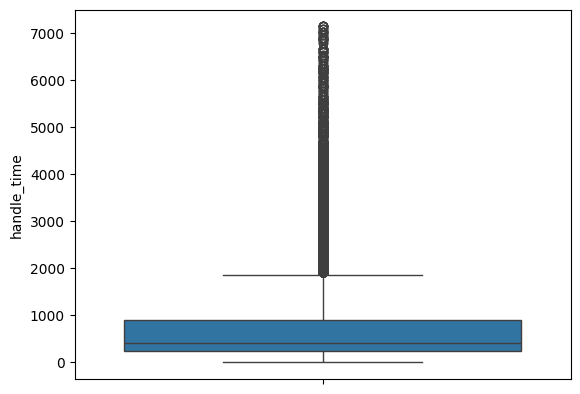

In [14]:
sns.boxplot(df['handle_time'])
plt.show()

In [48]:
# Clean call reasons to remove duplicates due to spaces/special characters
def clean_text(text):
    if isinstance(text, str):
        return re.sub(r'[-_]', ' ', text.strip().lower())
    return text

df['primary_call_reason'] = df['primary_call_reason'].apply(clean_text)

**Encoding categorical variables using LabelEncoder**

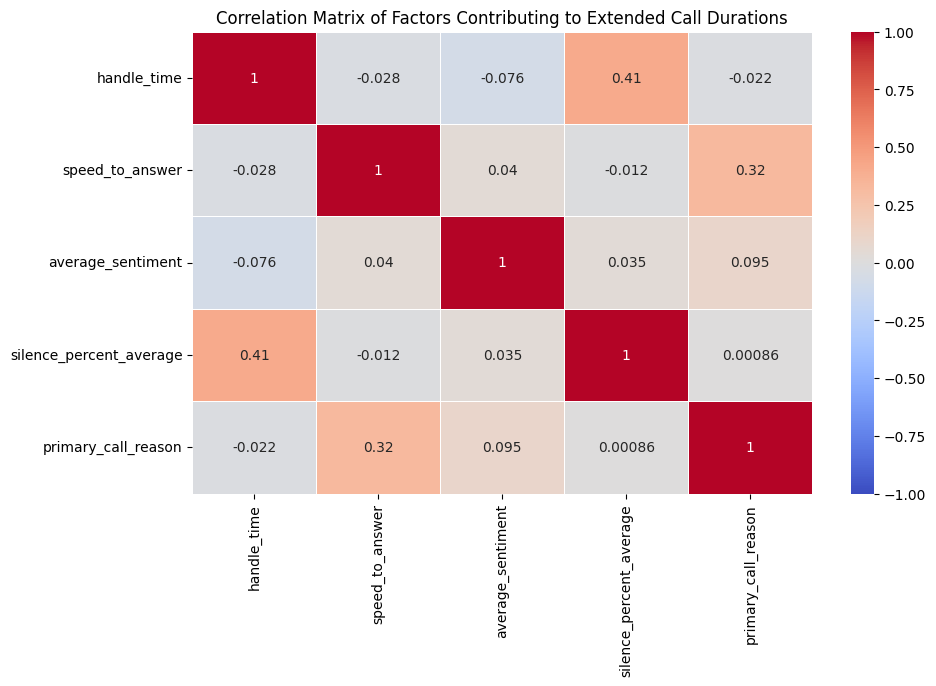

In [49]:
label_encoder = LabelEncoder()

# Encode 'primary_call_reason'
df['primary_call_reason'] = label_encoder.fit_transform(df['primary_call_reason'].astype(str))

# Encode 'agent_id'
df['agent_id_encoded'] = label_encoder.fit_transform(df['agent_id_x'].astype(str))

# Correlation analysis
correlation_data = df[['handle_time', 'speed_to_answer', 'average_sentiment', 'silence_percent_average',
                       'primary_call_reason']]

# Calculate the correlation matrix
correlation_matrix = correlation_data.corr()

# Plot the correlation matrix using a heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5, vmin=-1, vmax=1)
plt.title('Correlation Matrix of Factors Contributing to Extended Call Durations')
plt.show()

**Analyze call reasons**

In [50]:
call_type_analysis = df.groupby('primary_call_reason')['handle_time'].mean().reset_index()
call_type_analysis.columns = ['primary_call_reason', 'avg_handle_time']

**Pareto Chart for Call Reasons**

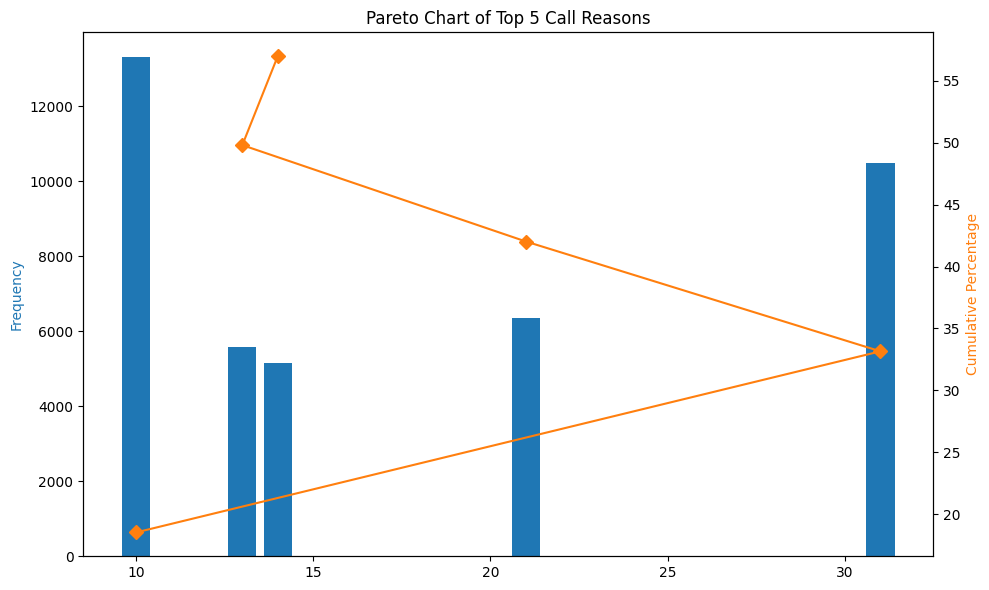

In [52]:
call_reason_freq = df['primary_call_reason'].value_counts().reset_index()
call_reason_freq.columns = ['primary_call_reason', 'frequency']

# Cumulative percentage for Pareto
call_reason_freq['cumulative_percentage'] = call_reason_freq['frequency'].cumsum() / call_reason_freq['frequency'].sum() * 100

# Pareto chart: bar and line chart
fig, ax1 = plt.subplots(figsize=(10,6))
ax1.bar(call_reason_freq['primary_call_reason'][:5], call_reason_freq['frequency'][:5], color='C0')
ax1.set_ylabel('Frequency', color='C0')
ax2 = ax1.twinx()
ax2.plot(call_reason_freq['primary_call_reason'][:5], call_reason_freq['cumulative_percentage'][:5], color='C1', marker='D', ms=7)
ax2.set_ylabel('Cumulative Percentage', color='C1')
plt.title('Pareto Chart of Top 5 Call Reasons')
plt.tight_layout()
plt.show()

**Percentage difference in AHT for most and least frequent reasons**

In [53]:
most_freq_reason = call_reason_freq['primary_call_reason'].iloc[0]
least_freq_reason = call_reason_freq['primary_call_reason'].iloc[-1]
most_freq_aht = df[df['primary_call_reason'] == most_freq_reason]['handle_time'].mean()
least_freq_aht = df[df['primary_call_reason'] == least_freq_reason]['handle_time'].mean()

if least_freq_aht != 0:
    percent_diff = ((most_freq_aht - least_freq_aht) / least_freq_aht) * 100
else:
    percent_diff = np.nan  # Avoid division by zero

print(f"Percentage difference in AHT between most frequent ({most_freq_reason}) and least frequent ({least_freq_reason}) call reasons: {percent_diff:.2f}%")

Percentage difference in AHT between most frequent (10) and least frequent (23) call reasons: 60.92%


**Sentiment Analysis with Pair Plot**

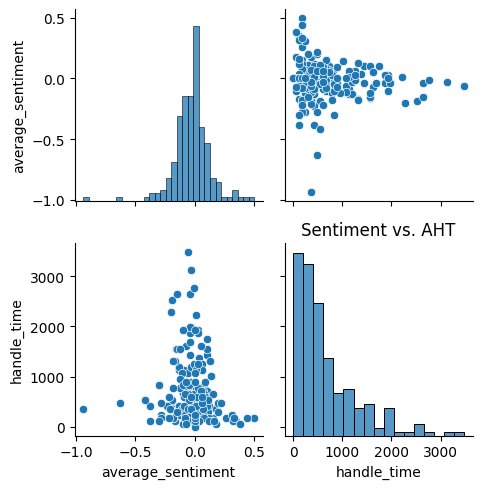

In [55]:
sentiment_analysis = df[['average_sentiment', 'handle_time']].head(200)
sns.pairplot(sentiment_analysis)
plt.title('Sentiment vs. AHT')
plt.tight_layout()
plt.show()

**Sentiment Analysis NLP**

In [25]:
# Simple Approach using Tokenization
# Using CountVectorizer to analyze call transcripts
vectorizer = CountVectorizer(stop_words='english')
X = vectorizer.fit_transform(df['call_transcript'].dropna().sample(1000))
words_freq = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())
top_words = words_freq.sum().sort_values(ascending=False).head(10)

print("Top 10 Most Frequent Words in Call Transcripts:")
print(top_words)

Top 10 Most Frequent Words in Call Transcripts:
flight     8673
change     3538
help       2805
work       1801
time       1742
need       1724
chicago    1612
looks      1561
really     1560
today      1506
dtype: int64


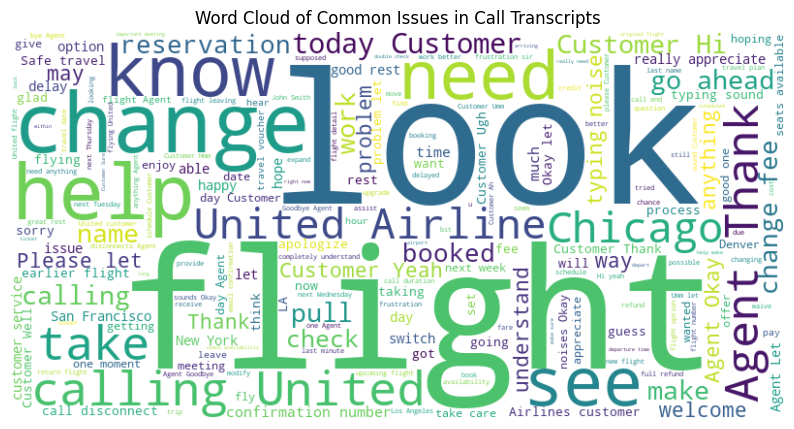

In [61]:
from wordcloud import WordCloud

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(df['call_transcript']))
# Plot the word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Common Issues in Call Transcripts')
plt.show()


In [16]:
category_counts = df['primary_call_reason'].value_counts()
top_categories = category_counts.nlargest(2).index.tolist()
df['target_modified'] = df['primary_call_reason'].apply(lambda x: x if x in top_categories else 'etc')
df.head()

,call_id,customer_id,agent_id_x,call_start_datetime,agent_assigned_datetime,call_end_datetime,call_transcript,primary_call_reason,agent_id_y,agent_tone,customer_tone,average_sentiment,silence_percent_average,customer_name,elite_level_code,handle_time,speed_to_answer,agent_id_encoded,target_modified
0,4667960400,2033123310,963118,2024-07-31 23:56:00,2024-08-01 00:03:00,2024-08-01 00:34:00,\n\nAgent: Thank you for calling United Airlin...,28,963118,neutral,angry,-0.04,0.39,Matthew Foster,4.0,1860.0,420.0,368,etc
1,1122072124,8186702651,519057,2024-08-01 00:03:00,2024-08-01 00:06:00,2024-08-01 00:18:00,\n\nAgent: Thank you for calling United Airlin...,1,519057,calm,neutral,0.02,0.35,Tammy Walters,0.0,720.0,180.0,163,etc
2,6834291559,2416856629,158319,2024-07-31 23:59:00,2024-08-01 00:07:00,2024-08-01 00:26:00,\n\nAgent: Thank you for calling United Airlin...,10,158319,neutral,polite,-0.13,0.32,Jeffery Dixon,0.0,1140.0,480.0,21,10
3,2266439882,1154544516,488324,2024-08-01 00:05:00,2024-08-01 00:10:00,2024-08-01 00:17:00,\n\nAgent: Thank you for calling United Airlin...,26,488324,neutral,frustrated,-0.20,0.20,David Wilkins,2.0,420.0,300.0,155,etc
4,1211603231,5214456437,721730,2024-08-01 00:04:00,2024-08-01 00:14:00,2024-08-01 00:23:00,\n\nAgent: Thank you for calling United Airlin...,21,721730,neutral,polite,-0.05,0.35,Elizabeth Daniels,0.0,540.0,600.0,254,etc


**Predicting Accuracy**

In [17]:
# Ensure all values in 'target_modified' are strings
df['target_modified'] = df['target_modified'].astype(str)

# Define feature and target variables
X = df[['call_id']]  # Keeping 'call_id' as the feature
y = df['target_modified']

# Split the data into training and test sets (70% training, 30% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Encode the target variable
le = LabelEncoder()
y_encoded_train = le.fit_transform(y_train.astype(str))  # Ensure y_train is of type string
y_encoded_test = le.transform(y_test.astype(str))  # Ensure y_test is of type string

# Convert data into DMatrix for XGBoost
dtrain = xgb.DMatrix(X_train, label=y_encoded_train)
dtest = xgb.DMatrix(X_test)

# Set parameters for XGBoost (multi-class classification)
params = {
    'objective': 'multi:softmax',
    'num_class': len(le.classes_)
}

# Train the XGBoost model
bst = xgb.train(params, dtrain, num_boost_round=100)

# Make predictions on the test set
y_pred = bst.predict(dtest)

# Evaluate the model
accuracy = accuracy_score(y_encoded_test, y_pred.astype(int))
print(f"Accuracy: {accuracy*100:.2f}%")

Accuracy: 66.83%
